# Soil moisture individual global figures for the multipanel Figure 1 of Chapter 12

## Produces the figures for:
- panel j: 2081-2100 ssp126 - historical (late-21st century)
- panel k: 2041-2060 ssp585 - historical (mid-21st century)
- panel l: 2081-2100 ssp585 - historical (late-21st century)
- the colorbar

# If you just want to do the figures using the final plotted data, 
# go to section 2

In [2]:
import os, glob
import xarray as xr
from IPython.display import Image
from PIL import Image as PILImage

In [9]:
CWD = os.getcwd()
outdatadir = CWD + '/../../data/Figure_12.4/SM'
outfigdir = CWD + '/../../figs/global_figure_12.4'

root_inputdatadir = '/thredds/ipsl/jservon/Chapter12/temporary_data_20210415'

In [4]:
variable = 'mrso'

# 1. Do the analyses to compute the ensemble medians and model agreement

## The input files are provided by Mathias Hauser
One file per model / experiment, with the whole period covered

Need to select the periods

### Import the CliMAF library to do the pretreatments (https://climaf.readthedocs.io/en/master/)

In [6]:
from climaf.api import *

CliMAF version = 1.2.13


CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post
python => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:
ncl 6.6.2 => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump fichier => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncdump
Check stamping requirements
nco (ncatted) found -> /opt/nco-4.5.2/bin/ncatted
convert found -> /usr/bin/convert
pdftk found -> /usr/bin/pdftk
exiv2 found -> /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post/bin/exiv2
---


Cache directory set to : /data/jservon/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/jservon/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


### Declare the access to the archive

In [10]:
#pattern = '/data/jservon/IPCC/spi/individual_models/'+CMIP+'/'+CMIP+'_${experiment}_${variable}_${period}_${member}.nc'
pattern = root_inputdatadir+'/mrso/data.iac.ethz.ch/IPCC_AR6/for_ch12/cmip6/mrso/sm_annmean_regrid_g010a/sm_annmean_regrid_g010a_${variable}_Lmon_${model}_${experiment}_${realization}_gn.nc'
cproject('mrso_individual_models_cmip6_ch12','experiment','model','realization',('variable',variable), ensemble=['model'], separator='%')
dataloc(project='mrso_individual_models_cmip6_ch12', url=pattern)    

<climaf.dataloc.dataloc instance at 0x2b737d260c20>

## Work on the individual models:
- create scenario and baseline ensembles => select common models
- compute annual sums
- compute climatologies
- compute differences

In [11]:
exp_list = [
    dict(experiment='ssp585',
         period = '2041-2060'),
    dict(experiment='ssp585',
         period = '2081-2100'),
    dict(experiment='ssp126',
         period = '2081-2100'),
]

# -- Create ensemble for historical baseline
# 1. Initial request to list all the models
req_baseline_dict = dict(project='mrso_individual_models_cmip6_ch12',
                         experiment = 'historical',
                         period = '1995-2004',
                         realization = '*'
                        )
req_baseline = ds(model='*', **req_baseline_dict)
# 2. Build the ensemble by hand to deal with the realizations
ens_baseline_dict = dict()
for model in req_baseline.explore('choices')['model']:
    ens_baseline_dict[model] = ds(model=model, **req_baseline_dict).explore('resolve')
ens_baseline = cens(ens_baseline_dict)

# -- Loop on the scenarios
ens_diff = dict()
for exp in exp_list:
    #
    # -- Experiment and period
    experiment = exp['experiment']
    period = exp['period']
    
    # -- Create ensemble object for the scenario
    # 1. Initial request to list all the models
    req_exp_dict = dict(project='mrso_individual_models_cmip6_ch12',
                        experiment = experiment,
                        period = period,
                        realization = '*'
                       )
    req_exp = ds(model='*', **req_exp_dict)
    # 2. Build the ensemble by hand to deal with the realizations
    ens_exp_dict = dict()
    for model in req_exp.explore('choices')['model']:
        ens_exp_dict[model] = ds(model=model, **req_exp_dict).explore('resolve')
    ens_exp = cens(ens_exp_dict)
    
    # -- Extract common members
    wens_baseline, wens_exp = ensemble_intersection([ens_baseline, ens_exp])
    #    
    # -- Climatologies
    clim_baseline = clim_average(wens_baseline, 'ANM')
    clim_exp      = clim_average(wens_exp, 'ANM')
    
    # -- Changes = Scenario minus baselines
    diff_exp_baseline = fmul( fdiv(fsub(clim_exp, clim_baseline), clim_baseline), 100)
    ens_diff[experiment+'_'+period] = diff_exp_baseline

### Plot parameters

In [12]:
pp_colorbar = dict(proj   = 'Robinson',
                   min = -5, max=5, delta=0.5,
                   color  = 'MPL_BrBG',#NCV_blu_red',
                   focus = 'land',
                   tiMainFontHeightF=0.03,
                   gsnStringFontHeightF=0.02,
                   gsnRightString='', gsnLeftString=''
                  )

In [13]:
pp = pp_colorbar.copy()
pp.update(
    dict(options='gsnAddCyclic=True|lbLabelBarOn=False|lbBoxEndCapStyle=TriangleBothEnds|mpGridAndLimbOn=True|mpGridLineColor=-1')
)         

In [14]:
clog('critical')

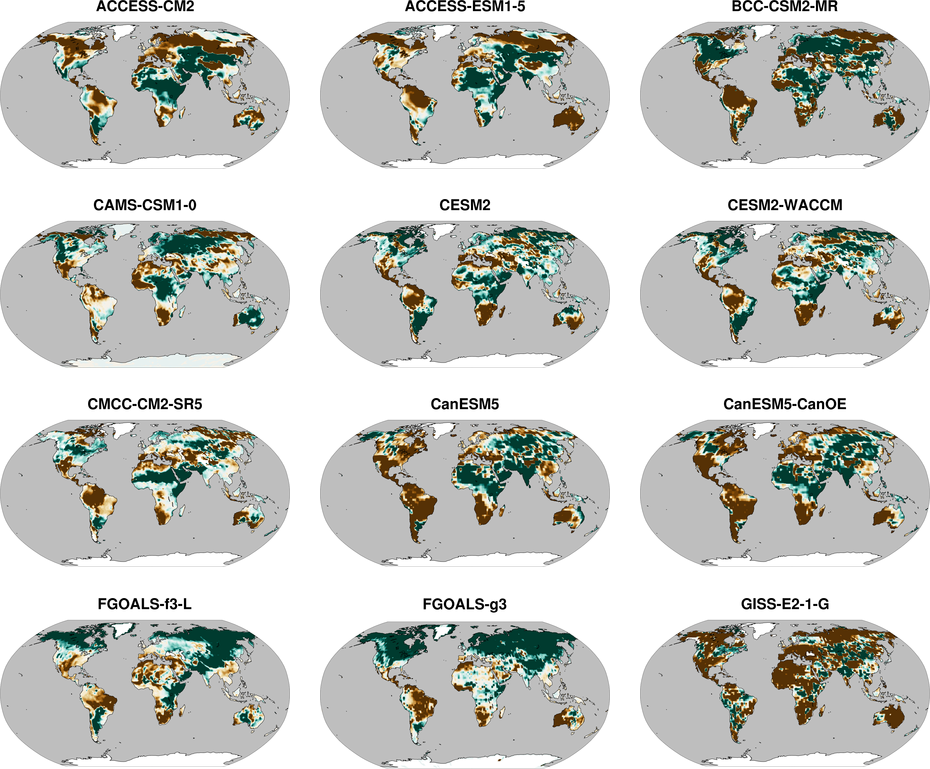

In [15]:
# -- Plot the individual models
wfuture = 'ssp585_2081-2100'
iplot_members(ens_diff[wfuture], N=1, **pp)

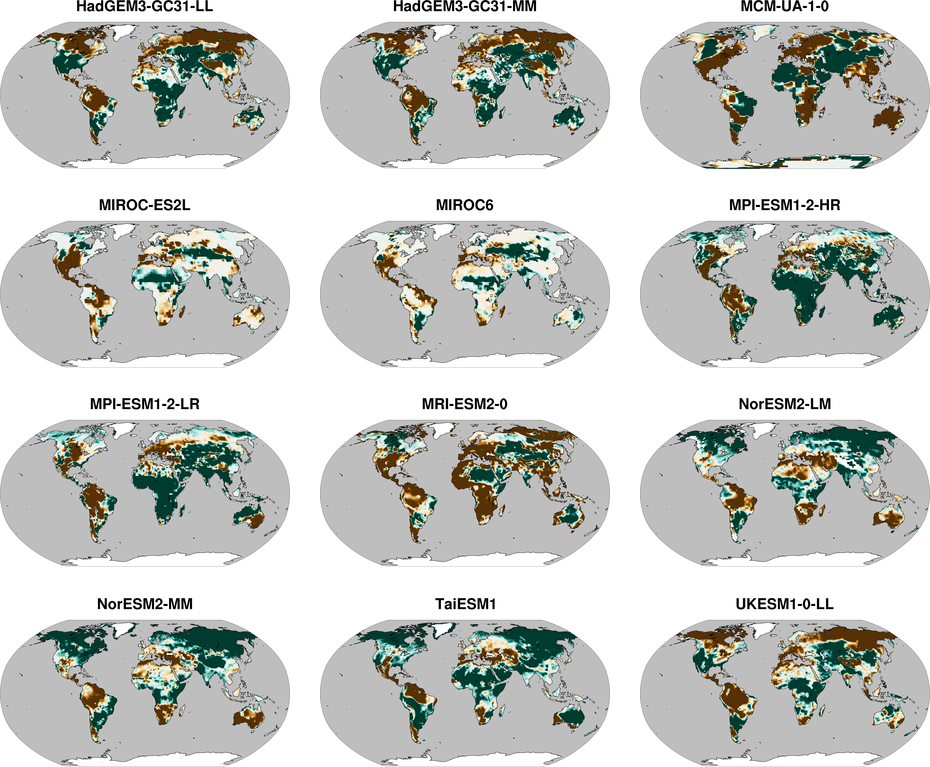

In [16]:
iplot_members(ens_diff[wfuture], N=2, **pp)

## Ensemble statistics

### Save the data to be plotted

In [18]:
perc_agreement = '80'

# -- Model agreement
# ------------------------------------------------
model_agreement_dict = dict()
for exp in exp_list:
    # -- Experiment and period
    experiment = exp['experiment']
    period = exp['period']
    wfuture = experiment+'_'+period

    # -- Mask of models with
    ens_mask_pos = ccdo(ens_diff[wfuture], operator='gtc,0')
    ens_mask_neg = ccdo(ens_diff[wfuture], operator='ltc,0')
    ens_mask_zero = ccdo(ens_diff[wfuture], operator='eqc,0')

    perc_ens_pos = fmul( fdiv( ccdo_ens(ens_mask_pos, operator='enssum'), len(ens_diff[wfuture]) ), 100 )
    perc_ens_neg = fmul( fdiv( ccdo_ens(ens_mask_neg, operator='enssum'), len(ens_diff[wfuture]) ), 100 )
    perc_ens_zero = fmul( fdiv( ccdo_ens(ens_mask_zero, operator='enssum'), len(ens_diff[wfuture]) ), 100 )

    # -- Signif90
    model_agreement_pos = ccdo(perc_ens_pos, operator='gtc,'+perc_agreement)
    model_agreement_neg = ccdo(perc_ens_neg, operator='gtc,'+perc_agreement)
    model_agreement_zero = ccdo(perc_ens_zero, operator='gtc,'+perc_agreement)
    model_agreement_dict[wfuture] = fmul( fadd( fadd(model_agreement_pos, model_agreement_neg), model_agreement_zero), -1)
    if wfuture=='ssp126_2081-2100':
        panel = 'panel_j'
    if wfuture=='ssp585_2041-2060':
        panel = 'panel_k'
    if wfuture=='ssp585_2081-2100':
        panel = 'panel_l'
    mask_agreement_name = outdatadir + '/mask_'+perc_agreement+'perc-agreement_SM_'+panel+'_'+wfuture+'_minus_baseline.nc'
    cfile(model_agreement_dict[wfuture], target=mask_agreement_name)
    cmd = 'ncatted -O -a comment,global,o,c,"This file is used for the hatching of '+panel+' of figure 12.4 - Chapter 12" '+mask_agreement_name
    os.system(cmd)
    

# -- Ensemble medians
# ------------------------------------------------
# -- Panel j
wfuture = 'ssp126_2081-2100'
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + '/SM_panel_j_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel j of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)

# -- Panel k
wfuture = 'ssp585_2041-2060'
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + '/SM_panel_k_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel k of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)

# -- Panel l
wfuture = 'ssp585_2081-2100'
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + '/SM_panel_l_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel l of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)

0

# 2. Save the figures and the colorbar

#### If you just want to do the figures, start from here

#### If you just want to do the figures, start from here

In [19]:
from climaf.api import *
import os
from IPython.display import Image
from PIL import Image as PILImage

CWD = os.getcwd()
outdatadir = CWD + '/../../data/Figure_12.4/SM'
outfigdir = CWD + '/../../figs/global_figure_12.4'

#### Plot parameters

In [37]:
pp_colorbar = dict(proj   = 'Robinson',
                   min = -5, max=5, delta=0.5,
                   color  = 'MPL_BrBG',#NCV_blu_red',
                   focus = 'land',
                   tiMainFontHeightF=0.03,
                   gsnStringFontHeightF=0.02,
                   gsnRightString='', gsnLeftString=''
                  )
pp = pp_colorbar.copy()
pp.update(
    dict(options='gsnAddCyclic=True|lbLabelBarOn=False|lbBoxEndCapStyle=TriangleBothEnds|mpGridAndLimbOn=True|mpGridLineColor=-1',
         tiMainFontHeightF = 0.032,
         gsnStringFontHeightF = 0.03

        )
)         

#### Do the plots of panels j, k and l

In [38]:
# -- variable
variable = 'mrso'

# -- Percentage of model agreement (hatching)
perc_agreement = '80'

# -- Panel j
# --------------------------------------------------
wfuture = 'ssp126_2081-2100'
ensmedian_filename = outdatadir + '/SM_panel_j_'+wfuture+'_minus_baseline.nc'
ensmedian_field = fds(ensmedian_filename, period='fx', variable=variable)
model_agreement_filename = outdatadir + '/mask_'+perc_agreement+'perc-agreement_SM_panel_j_'+wfuture+'_minus_baseline.nc'
model_agreement_field = fds(model_agreement_filename, period='fx', variable=variable)
# -- Save in png
panel_j = plot_ipcc(ensmedian_field,
                    model_agreement_field,
                    shade_above = -0.99999,
                    shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                    gsnCenterString = 'Change in soil moisture',
                    title = '2081-2100, SSP1-2.6',
                    **pp
                    )
cfile(panel_j, target = outfigdir + '/panel_j_'+ variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')
# -- Save in pdf
panel_j_pdf = plot_ipcc(ensmedian_field,
                        model_agreement_field,
                        shade_above = -0.99999,
                        shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                        gsnCenterString = 'Change in soil moisture',
                        title = '2081-2100, SSP1-2.6',
                        format='pdf',
                        **pp
                        )
cfile(cpdfcrop(panel_j_pdf), target = outfigdir + '/panel_j_'+ variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')




# -- Panel k
# --------------------------------------------------
wfuture = 'ssp585_2041-2060'
ensmedian_filename = outdatadir + '/SM_panel_k_'+wfuture+'_minus_baseline.nc'
ensmedian_field = fds(ensmedian_filename, period='fx', variable=variable)
model_agreement_filename = outdatadir + '/mask_'+perc_agreement+'perc-agreement_SM_panel_k_'+wfuture+'_minus_baseline.nc'
model_agreement_field = fds(model_agreement_filename, period='fx', variable=variable)
# -- Save in png
panel_k = plot_ipcc(ensmedian_field,
                    model_agreement_field,
                    shade_above = -0.99999,
                    shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                    gsnCenterString = 'Change in soil moisture',
                    title = '2041-2060, SSP5-8.5',
                    **pp
                    )
cfile(panel_k, target = outfigdir + '/panel_k_'+ variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')
# -- Save in pdf
panel_k_pdf = plot_ipcc(ensmedian_field,
                        model_agreement_field,
                        shade_above = -0.99999,
                        shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                        gsnCenterString = 'Change in soil moisture',
                        title = '2041-2060, SSP5-8.5',
                        format='pdf',
                        **pp
                        )
cfile(cpdfcrop(panel_k_pdf), target = outfigdir + '/panel_k_'+ variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')

# -- Panel l
# --------------------------------------------------
wfuture = 'ssp585_2081-2100'
ensmedian_filename = outdatadir + '/SM_panel_l_'+wfuture+'_minus_baseline.nc'
ensmedian_field = fds(ensmedian_filename, period='fx', variable=variable)
model_agreement_filename = outdatadir + '/mask_'+perc_agreement+'perc-agreement_SM_panel_l_'+wfuture+'_minus_baseline.nc'
model_agreement_field = fds(model_agreement_filename, period='fx', variable=variable)
# -- Save in png
panel_l = plot_ipcc(ensmedian_field,
                    model_agreement_field,
                    shade_above = -0.99999,
                    shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                    gsnCenterString = 'Change in soil moisture',
                    title = '2081-2100, SSP5-8.5',
                    **pp
                    )
cfile(panel_l, target = outfigdir + '/panel_l_'+ variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')
# -- Save in pdf
panel_l_pdf = plot_ipcc(ensmedian_field,
                        model_agreement_field,
                        shade_above = -0.99999,
                        shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                        gsnCenterString = 'Change in soil moisture',
                        title = '2081-2100, SSP5-8.5',
                        format='pdf',
                        **pp
                        )
cfile(cpdfcrop(panel_l_pdf), target = outfigdir + '/panel_l_'+ variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')


'/home/jservon/Chapter12_IPCC/WG1_github/Chapter-12/Figures/figs/global_figure_12.4/panel_l_mrso_ssp585_2081-2100_80perc-agreement.pdf'

#### Plot the colorbar

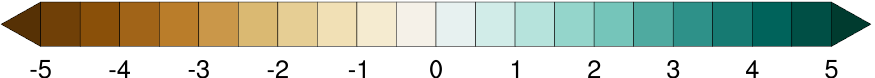

In [36]:
# -- Colorbar
def extract_labelbar(figure_file,labelbar_file) :
    #import PIL
    im = PILImage.open(figure_file)
    im_crop = im.crop((55, 563, 930, 641))
    im_crop.save(labelbar_file, quality=95)

# -- pdf
plot_4colorbar = plot_ipcc(ensmedian_field,
                      options='lbOrientation=horizontal|lbLabelFontHeightF=0.015|lbBoxEndCapStyle=TriangleBothEnds',
                           format='pdf',
                      **pp_colorbar)
colorbar_file = outfigdir+'/'+variable+'_colorbar.pdf'
cfile(cpdfcrop(plot_4colorbar), target=colorbar_file)

# -- png
plot_4colorbar = plot_ipcc(ensmedian_field,
                      options='lbOrientation=horizontal|lbLabelFontHeightF=0.015|lbBoxEndCapStyle=TriangleBothEnds',
                      **pp_colorbar)
colorbar_file = outfigdir+'/'+variable+'_colorbar.png'

# -- Extract the colorbar
extract_labelbar(cfile(plot_4colorbar),colorbar_file)

Image(colorbar_file)

#### Do the final multiplot

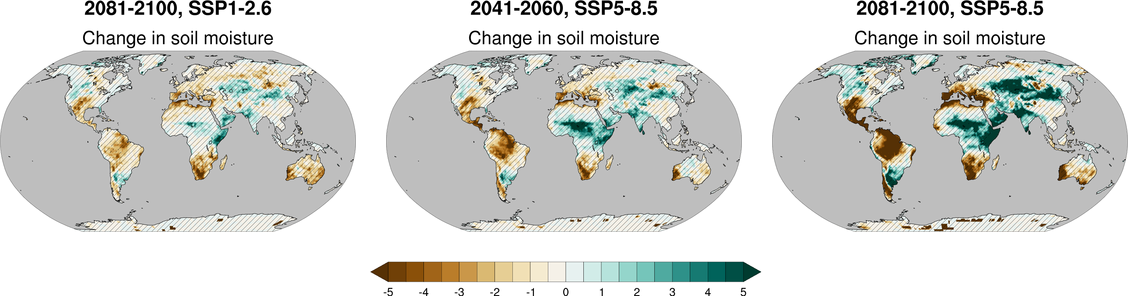

In [39]:
mp = cpage(fig_lines=[[panel_j,panel_k,panel_l]],
            insert=colorbar_file,
            insert_width=400, page_width=1200
          )
iplot(mp)